In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
    
import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-04-05 02:56:05.471552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 02:56:07.093414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-04-05 02:56:07.095098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10545 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [4]:
credit_dsa = {}
log_credit_dsa = {}

for split in [4,3,2]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="relu")
    credit_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_credit_dsa[split] = credit_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Split level is 4======
Iteration 500, train accuracy: 0.7838492642641067, average attack MSE: 0.14070345708727836
Iteration 1000, train accuracy: 0.8053683233261109, average attack MSE: 0.12233931602537632
Iteration 1500, train accuracy: 0.8093169816732406, average attack MSE: 0.09930307081341744
Iteration 2000, train accuracy: 0.8122283467054368, average attack MSE: 0.0778368408381939
Iteration 2500, train accuracy: 0.8137838308811187, average attack MSE: 0.06306925559788942
Iteration 3000, train accuracy: 0.8146387076377869, average attack MSE: 0.0486491901576519
Iteration 3500, train accuracy: 0.8151478451490403, average attack MSE: 0.03736092521622777
Iteration 4000, train accuracy: 0.8160095974206925, average attack MSE: 0.03209839066118002
Iteration 4500, train accuracy: 0.816870023727417, average attack MSE: 0.03008353628963232
Iteration 5000, train accuracy: 0.8172437039613724, average attack MSE: 0.030148071449249983
Iteration 5500, train accuracy: 0.8176755431890488, av

In [5]:
from fsha import *

credit_fsha={}
log_credit_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp_fsha(attr_num=23, class_num=2, split=split, units=64, ed_act=None)
    models = (make_f, make_g, make_e, make_d, make_c)
    credit_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_credit_fsha[split]=credit_fsha[split](10000, verbose=True, progress_bar=False, log_frequency=1000)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.8438, validation: 0.1467
Iteration 0001000 train accuracy: 0.7706, validation: 0.0806
Iteration 0002000 train accuracy: 0.7801, validation: 0.0864
Iteration 0003000 train accuracy: 0.7801, validation: 0.0605
Iteration 0004000 train accuracy: 0.7803, validation: 0.0363
Iteration 0005000 train accuracy: 0.7806, validation: 0.0254
Iteration 0006000 train accuracy: 0.7807, validation: 0.0218
Iteration 0007000 train accuracy: 0.7807, validation: 0.0213
Iteration 0008000 train accuracy: 0.7807, validation: 0.0210
Iteration 0009000 train accuracy: 0.7808, validation: 0.0203
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.5938, validation: 0.1477
Iteration 0001000 train accuracy: 0.7788, validation: 0.0802
Iteration 0002000 train accuracy: 0.7808, validation: 0.0846
Iteration 0003000 train accuracy: 0.7807, validation: 0.0567
Iteration 0004000 train accuracy: 0.7810, validation: 0.0345
Itera

In [6]:
with open('log/credit-dsa.pkl', 'wb') as f:
    pickle.dump(log_credit_dsa, f)
with open('log/credit-fsha.pkl', 'wb') as f:
    pickle.dump(log_credit_fsha, f)

In [7]:
with open('log/credit-dsa.pkl', 'rb') as f:
    log_credit_dsa = pickle.load(f)
with open('log/credit-fsha.pkl', 'rb') as f:
    log_credit_fsha = pickle.load(f)

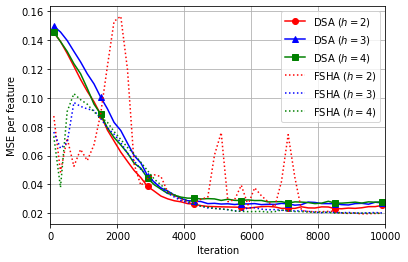

In [9]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_credit_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_credit_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_loss[2], 'r:', ran, sampled_fsha_loss[3], 'b:', ran, sampled_fsha_loss[4], 'g:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/credit.pdf", bbox_inches='tight')

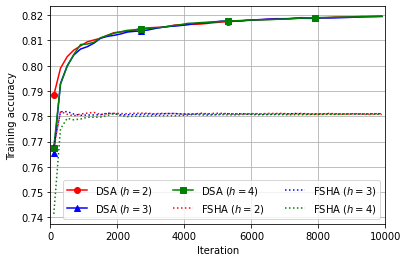

In [11]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_credit_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_credit_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_acc[2], 'r:', ran, sampled_fsha_acc[3], 'b:', ran, sampled_fsha_acc[4], 'g:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"], ncol=3)
plt.savefig("fig/credit-acc.pdf", bbox_inches='tight')